<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/04%20Clasificaci%C3%B3n%20y%20Agrupamiento/notebooks/07-RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest

<img align="left" width="350" src="../img/random-forest.jpeg"/>

## El conjunto de datos

Este dataset fue creado por el *National Institute of Diabetes and Digestive and Kidney Diseases* de Estados Unidos. El objetivo del dataset es predecir el diagnostico de cuándo un paciente tiene diabetes o no, basado en ciertas mediciones incluidas en el dataset. Varias restricciones fueron usadas en la selección de estas instancias para filtrar el dataset. En particular, se trata pacientes femeninas de al menos 21 años de edad pertenecientes al grupo indígena Pima de Arizona.

Las variables incluidas son el numero de embarazos la paciente ha tenido, su BMI, nivel de insulina, edad, entre otras.

El dataset se encuentra en https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

In [1]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP_2022/trunk/04%20Clasificaci%C3%B3n%20y%20Agrupamiento/data/"

A    data/creditcard.zip
A    data/diabetes.csv
A    data/frequencia_palabras.csv
Checked out revision 85.


In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score


df = pd.read_csv("/content/data/diabetes.csv") # cargamos el dataset
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
rename_dict = dict(zip(df.columns.to_list(),col_names))
df.rename(columns=rename_dict, inplace=True)
display(df.tail(4))


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


## Preprocesamiento y Entrenamiento

No tomaremos en cuenta la columna *bmi* por la cantidad de valores 0. También podríamos quitar esas instancias

Hay (11,) valores cero de 768.


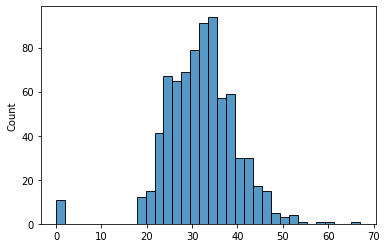

In [7]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Hay {np.where(df['bmi'].values==0)[0].shape} valores cero de {df['bmi'].values.shape[0]}.")

plt.figure()
sns.histplot(df['bmi'].values)
plt.show()

In [8]:
# ----- Definimos las features
feature_cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'age']

X = df[feature_cols].values    # Features
y = df['label'].values         # Target variable

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = RandomForestClassifier(n_jobs=-1)  # Create Decision Tree classifier object

clf = clf.fit(X_train,y_train)  # Train Decision Tree Classifier
y_pred = clf.predict(X_test)    # Predict the response for test dataset

¿Cómo lo hizo en el conjunto de prueba?

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

y_train_pred = clf.predict(X_train)

print(f"Accuracy: {round(accuracy_score(y_train,y_train_pred),3)}")
print(f"Recall: {round(recall_score(y_train,y_train_pred),3)}")
print(f"Precision: {round(precision_score(y_train,y_train_pred),3)}")

print(f"Accuracy, usando el método score: {clf.score(X_train,y_train)}")

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
Accuracy, usando el método score: 1.0


## Resultados

Accuracy: 0.784
Recall: 0.62353
Precision: 0.746


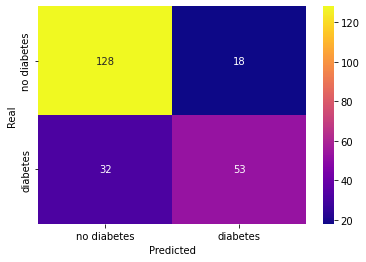

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score

print(f"Accuracy: {round(accuracy_score(y_test,y_pred),3)}")
print(f"Recall: {round(recall_score(y_test,y_pred),5)}")
print(f"Precision: {round(precision_score(y_test,y_pred),3)}")

target_labels = ['no diabetes','diabetes']

plt.figure()
cm = confusion_matrix(y_test,y_pred)
s_cm = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
s_cm.set(xlabel='Predicted',ylabel='Real')
plt.show()

Podemos obtener la importancia de las features de acuerdo a la reducción de impureza de los nodos donde participan. 

In [12]:
importances = pd.DataFrame({'feature':feature_cols,'importancia':np.round(clf.feature_importances_,3)})
importances.sort_values(by='importancia',ascending=False,inplace=True)
importances.set_index('feature')

,importancia
feature,
glucose,0.317
age,0.203
bp,0.148
pregnant,0.124
skin,0.111
insulin,0.098


## Exploración del random forest

Podemos explorar el conjunto de árboles de decisión construidos por el random forest mediante la lista `estimators_`. Cada elemento de esta lista es un árbol de decisión como los que usamos la sesión pasada.

¿Cuántos árboles se usaron?

In [13]:
print(f"Número de árboles: {len(clf.estimators_)}")

Número de árboles: 100


Analicemos la predicción para un elemento arbitrario de X_test

In [14]:
import numpy as np

idx0 = 37
new_x = X_test[idx0]
print(f"Etiqueta real: {y_test[idx0]}, Preddición: {y_pred[idx0]}")

predicciones = []
for dt in clf.estimators_:
    predicted_label = int(dt.predict([X_test[idx0]])[0])  # No podemos pasar sólo un renglón de X_test, tiene que ser una matriz, por lo que pasamos una matriz de tamaño 1 x num_features
    predicciones.append(predicted_label)

# #Usando list comprehension:
# predicciones = [int(dt.predict([X_test[idx0]])[0]) for dt in clf.estimators_] 

print(f"Las primeras 10 predicciones: {predicciones[:10]}")

# ---- Contamos cuántos votos tuvo cada etiqueta por parte del bosque ----

zeros = np.where(np.array(predicciones)==0)[0]
ones = np.where(np.array(predicciones)==1)[0]

print(f"{zeros.shape[0]} árboles que predijeron la etiqueta 0:\n{zeros}\n")
print(f"{ones.shape[0]} Árboles que predijeron la etiqueta 1:\n{ones}\n")

Etiqueta real: 0, Preddición: 0
Las primeras 10 predicciones: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
90 árboles que predijeron la etiqueta 0:
[ 0  1  3  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 24 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 41 43 44 45 46 47 48 49 50 51 52 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 99]

10 Árboles que predijeron la etiqueta 1:
[ 2  6 18 23 25 40 42 53 73 98]



Exploremos un árbol arbitrario del ensamble. 

In [15]:
from sklearn import tree

dt = clf.estimators_[1]

print(f"Profundidad del árbol: {dt.get_depth()}")
print(f"Número de hojas del árbol: {dt.get_n_leaves()}")

text_representation = tree.export_text(decision_tree=dt,
                                    feature_names=feature_cols)
# print(text_representation)

Profundidad del árbol: 16
Número de hojas del árbol: 106


Exploremos estadísticamente todos los árboles individuales del ensamble

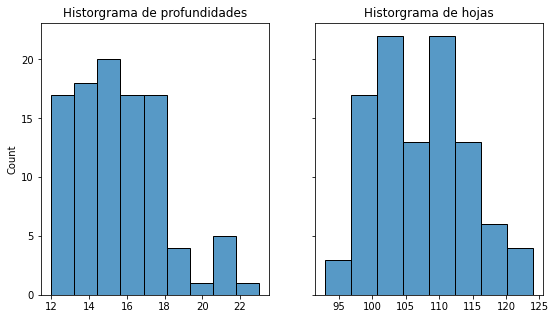

In [16]:
import seaborn as sns

profundidades = [dt.get_depth() for dt in clf.estimators_]
hojas = [dt.get_n_leaves() for dt in clf.estimators_]

fig, axs = plt.subplots(1,2,figsize=(9,5),sharey=True)
axs[0].set_title("Historgrama de profundidades")
sns.histplot(profundidades,ax=axs[0])
axs[1].set_title("Historgrama de hojas")
sns.histplot(hojas,ax=axs[1])
fig.show()


## Comparación con el DecisionTreeClassifier

Cargamos el clasificador de la sesión anterior. El formato *pickle* nos permite guardar (serializar) una gran variedad de datos y objetos sin ocupar tanto espacio. Para hacerlo usamos el módulo `pickle` o los métodos de cada módulo para guardar en pickle (por ejemplo, el método `to_pickle()` de pandas).

**Importante:** Al usar el formato pickle es muy importante contar con las mismas versiones en la instalación de python donde se genera el archivo y donde se leerá. De otra forma, es muy posible que sea imposible leer el archivo.

In [ ]:
import pickle

filename = '/content/best_dt_classifier.model'

with open(filename, 'rb') as f:
    single_dt = pickle.load(f)

Características

In [ ]:
print(f"Profundidad del árbol: {single_dt.get_depth()}")
print(f"Número de hojas del árbol: {single_dt.get_n_leaves()}")

Profundidad del árbol: 5
Número de hojas del árbol: 14


❓ **Algunas preguntas:**

Comparando el ensamble contra el árbol de la sesión pasada,

1. ¿Cuál es más complejo?
2. ¿Cuál produce mejores resultados? 

---



⭐ **Ejercicio**:

Encuentra el árbol del ensamble con el mejor rendimiento, respecto al accuracy, y compararlo con el árbol de la sesión pasada. 

In [ ]:
scores = [dt.score(X_test,y_test) for dt in clf.estimators_]

idx = np.argmax(scores)
best_tree = clf.estimators_[idx]

print(max(scores))

0.7705627705627706


⭐ **Práctica-Tarea**:

1. ¿Puedes subir las métricas de desempeño de este clasificador en este dataset? Prueba las siguientes modificaciones:

    * Cambiar el conjunto de features, ya sea manualmente o con algún método como [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html), [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), etc.
    * Normalizar de datos usando el [escalamiento MinMax](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [Normalización](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). ¿Tiene algún efecto considerable?
    * Realizar un gridsearch en los principales parámetros del clasificador: 
        * n_estimators
        * max_depth
        * min_samples_split
        * min_samples_leaf

2. ¿Qué estrategia rindió mejores resultados? Explorar los árboles de decisión individuales del ensamble. ¿Cómo se compara, en estos rubros (feature selection, normalización), con el decision tree?

3. Comparar el desempeño de ambos clasificadores (decision tree y random forest) en los conjuntos de prueba y test.

4. ¿Puedes subir las métricas de desempeño que obtuviste usando otro clasificador?

5. Realizar una notebook por equipo que incluya el código mostrando cada uno de los pasos anteriores, con el texto explicando cada parte del proceso. También incluir las respuestas a las preguntas formuladas en los puntos anteriores.


*Deadline: Viernes 3 de junio*

